In [23]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 80)
pd.set_option('display.max_colwidth', 50)

In [3]:
# # Replace the paths with the actual paths to your JSON files
# kiosk_data_json_path = '../../data/raw/metro_bike_kiosks.json'
# trip_data_csv_path = '../../data/raw/Austin_MetroBike_Trips_20231231.csv'
# trip_data_json_path = '../../data/raw/Austin_MetroBike_Trips.json'

# try:
#     # Loading the kiosk data into a DataFrame
#     kiosk_df = pd.read_json(kiosk_data_json_path)

#     dtype_dict = {
#         'Trip ID': 'int64',
#         'Membership or Pass Type': 'str',
#         'Bicycle ID': 'str',
#         'Bike Type': 'str',
#         'Checkout Datetime': 'str',  # or 'datetime64' if you want to parse dates
#         'Checkout Date': 'str',  # or 'datetime64'
#         'Checkout Time': 'str',
#         'Checkout Kiosk ID': 'str',
#         'Checkout Kiosk': 'str',
#         'Return Kiosk ID': 'str',
#         'Return Kiosk': 'str',
#         'Trip Duration Minutes': 'int64',
#         'Month': 'str',
#         'Year': 'int64'
#     }

#     trip_df = pd.read_json(trip_data_json_path, lines=True)

#     # Normalizing the 'location' column and splitting it into 'latitude' and 'longitude'
#     location_df = pd.json_normalize(kiosk_df['location'])
#     kiosk_df = pd.concat([kiosk_df.drop(columns=['location']), location_df], axis=1)

#     dtype_dict = {
#         'Trip ID': 'int64',
#         'Membership or Pass Type': 'str',
#         'Bicycle ID': 'str',
#         'Bike Type': 'str',
#         'Checkout Datetime': 'str',  # or 'datetime64' if you want to parse dates
#         'Checkout Date': 'str',  # or 'datetime64'
#         'Checkout Time': 'str',
#         'Checkout Kiosk ID': 'str',
#         'Checkout Kiosk': 'str',
#         'Return Kiosk ID': 'str',
#         'Return Kiosk': 'str',
#         'Trip Duration Minutes': 'int64',
#         'Month': 'str',
#         'Year': 'int64'
#     }

#     # # Load the CSV file into a DataFrame
#     # trip_df = pd.read_csv(trip_data_csv_path, dtype=dtype_dict)

#     # # Save the DataFrame as a JSON file
#     # trip_df.to_json(trip_data_json_path, orient='records')

#     # Displaying the dataframes
#     display(trip_df)
#     display(kiosk_df)

#     # Displaying the total number of rows in each DataFrame
#     print("Total rows in kiosk_df:", len(kiosk_df))
#     print("Total rows in trip_df:", len(trip_df))

# except Exception as e:
#     print("An error occurred:", e)

In [4]:
# Load the JSON file into a DataFrame
json_file_path = '../../data/raw/Austin_MetroBike_Trips.json'
kiosk_data_json_path = '../../data/raw/metro_bike_kiosks.json'

# Loading the kiosk data into a DataFrame
kiosk_df = pd.read_json(kiosk_data_json_path)

# Normalizing the 'location' column and splitting it into 'latitude' and 'longitude'
location_df = pd.json_normalize(kiosk_df['location'])
kiosk_df = pd.concat([kiosk_df.drop(columns=['location']), location_df], axis=1)

data_df = pd.read_json(json_file_path)

#display(data_df)

In [5]:
# Assuming 'Kiosk ID' is the common column in kiosk_df
# Rename columns in kiosk_df for merging
kiosk_df_checkout = kiosk_df.rename(columns={'kiosk_id': 'Checkout Kiosk ID', 'latitude': 'Checkout_Kiosk_Lat', 'longitude': 'Checkout_Kiosk_Long'})
kiosk_df_return = kiosk_df.rename(columns={'kiosk_id': 'Return Kiosk ID', 'latitude': 'Return_Kiosk_Lat', 'longitude': 'Return_Kiosk_Long'})

# Convert 'Checkout Kiosk ID' in data_df to integer, handling non-numeric values and NaNs
data_df['Checkout Kiosk ID'] = pd.to_numeric(data_df['Checkout Kiosk ID'], errors='coerce').fillna(0).astype(int)

# Convert 'Return Kiosk ID' in data_df to integer, handling non-numeric values and NaNs
data_df['Return Kiosk ID'] = pd.to_numeric(data_df['Return Kiosk ID'], errors='coerce').fillna(0).astype(int)

# Convert 'Return Kiosk ID' in kiosk_df_return to integer
kiosk_df_return['Return Kiosk ID'] = pd.to_numeric(kiosk_df_return['Return Kiosk ID'], errors='coerce').fillna(0).astype(int)

# Convert 'Checkout Kiosk ID' in kiosk_df_checkout to integer
kiosk_df_checkout['Checkout Kiosk ID'] = pd.to_numeric(kiosk_df_checkout['Checkout Kiosk ID'], errors='coerce').fillna(0).astype(int)

# Merge data_df with kiosk_df on 'Checkout Kiosk'
data_df = pd.merge(data_df, kiosk_df_checkout[['Checkout Kiosk ID', 'Checkout_Kiosk_Lat', 'Checkout_Kiosk_Long']], on='Checkout Kiosk ID', how='left')

# Merge data_df with kiosk_df on 'Return Kiosk'
data_df = pd.merge(data_df, kiosk_df_return[['Return Kiosk ID', 'Return_Kiosk_Lat', 'Return_Kiosk_Long']], on='Return Kiosk ID', how='left')

# Creating a debug DataFrame for NaN values
kiosk_missing_data_df = data_df[data_df[['Checkout_Kiosk_Lat', 'Checkout_Kiosk_Long', 'Return_Kiosk_Lat', 'Return_Kiosk_Long']].isna().any(axis=1)]

# Filtering kiosk_missing_data_df for rows where 'Checkout_Kiosk_Lat' and 'Checkout_Kiosk_Long' are NaN
nan_checkout_kiosk_df = kiosk_missing_data_df[kiosk_missing_data_df[['Checkout_Kiosk_Lat', 'Checkout_Kiosk_Long']].isna().any(axis=1)]

# Filtering kiosk_missing_data_df for rows where 'Return_Kiosk_Lat' and 'Return_Kiosk_Long' are NaN
nan_return_kiosk_df = kiosk_missing_data_df[kiosk_missing_data_df[['Return_Kiosk_Lat', 'Return_Kiosk_Long']].isna().any(axis=1)]

# Getting unique Return Kiosk IDs where 'Return_Kiosk_Lat' and 'Return_Kiosk_Long' are NaN
unique_return_ids = nan_return_kiosk_df['Return Kiosk ID'].unique()

# Getting unique Checkout Kiosk IDs where 'Checkout_Kiosk_Lat' and 'Checkout_Kiosk_Long' are NaN
unique_checkout_ids = nan_checkout_kiosk_df['Checkout Kiosk ID'].unique()

# Converting numpy arrays to lists before concatenation
unique_checkout_ids_list = unique_checkout_ids.tolist()
unique_return_ids_list = unique_return_ids.tolist()

# Consolidating and sorting
unique_kiosk_ids = sorted(set(unique_checkout_ids_list + unique_return_ids_list))

# Printing a descriptive message with count
print(f"Total unique kiosk IDs found in both 'Checkout Kiosk ID' and 'Return Kiosk ID' columns: {len(unique_kiosk_ids)}")
print(f"Unique kiosk IDs missing from Kiosk fact table: {unique_kiosk_ids}")

Total unique kiosk IDs found in both 'Checkout Kiosk ID' and 'Return Kiosk ID' columns: 12
Unique kiosk IDs missing from Kiosk fact table: [3456, 4938, 7125, 7131, 7186, 7187, 7188, 7189, 7190, 7253, 7341, 7637]


In [6]:
# Filtering out rows with null values in any of the four specified columns
filtered_df = data_df.dropna(subset=['Checkout_Kiosk_Lat', 'Checkout_Kiosk_Long', 'Return_Kiosk_Lat', 'Return_Kiosk_Long'])

# Filtering filtered_df for rows where 'Checkout Kiosk ID' is equal to 'Return Kiosk ID' 
# to exlcude trips that end where they started
filtered_df2 = filtered_df[~(filtered_df['Checkout Kiosk ID'] == filtered_df['Return Kiosk ID'])]

# Filtering out rows with inactive kiosks
active_kiosks = kiosk_df[kiosk_df['kiosk_status'] == 'active']['kiosk_id']
filtered_df3 = filtered_df2[(filtered_df2['Checkout Kiosk ID'].isin(active_kiosks)) & (filtered_df2['Return Kiosk ID'].isin(active_kiosks))]

# Grouping by Year and Month to count trips (All kiosks)
year_month_trip_df_all = filtered_df2.groupby(['Year', 'Month']).size().reset_index(name='Trip Count')

# Creating a combined year_month column
year_month_trip_df_all['Year_Month'] = pd.to_datetime(year_month_trip_df_all[['Year', 'Month']].assign(DAY=1))
year_month_trip_df_all = year_month_trip_df_all.sort_values('Year_Month')

# Adding rolling averages
year_month_trip_df_all['3 Month MA'] = year_month_trip_df_all['Trip Count'].rolling(window=3).mean()
year_month_trip_df_all['6 Month MA'] = year_month_trip_df_all['Trip Count'].rolling(window=6).mean()
year_month_trip_df_all['12 Month MA'] = year_month_trip_df_all['Trip Count'].rolling(window=12).mean()

# Grouping by Year and Month to count trips (Active Kiosks only)
year_month_trip_df_active_only = filtered_df3.groupby(['Year', 'Month']).size().reset_index(name='Trip Count')

# Creating a combined year_month column
year_month_trip_df_active_only['Year_Month'] = pd.to_datetime(year_month_trip_df_active_only[['Year', 'Month']].assign(DAY=1))
year_month_trip_df_active_only = year_month_trip_df_active_only.sort_values('Year_Month')

# Adding rolling averages
year_month_trip_df_active_only['3 Month MA'] = year_month_trip_df_active_only['Trip Count'].rolling(window=3).mean()
year_month_trip_df_active_only['6 Month MA'] = year_month_trip_df_active_only['Trip Count'].rolling(window=6).mean()
year_month_trip_df_active_only['12 Month MA'] = year_month_trip_df_active_only['Trip Count'].rolling(window=12).mean()


Original DataFrame (data_df) rows: 2112263
Rows after removing rows invalid Kiosk ID's: 1965145
Rows after removing trips with identical checkout/return Kiosks: 1675864


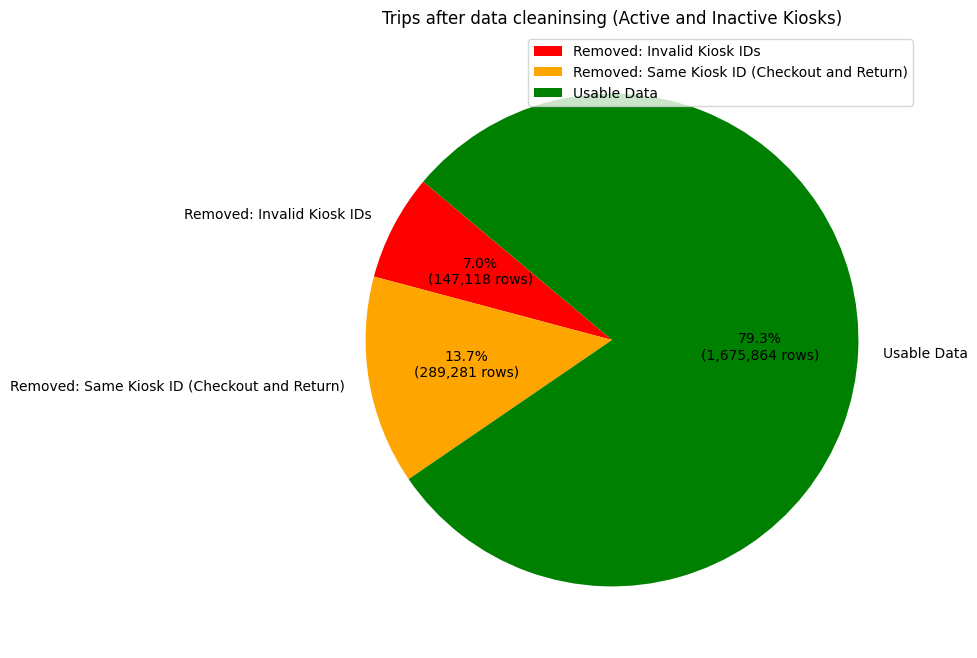

In [7]:
# Printing the number of rows in each DataFrame
print(f"Original DataFrame (data_df) rows: {len(data_df)}")
print(f"Rows after removing rows invalid Kiosk ID's: {len(filtered_df)}")
print(f"Rows after removing trips with identical checkout/return Kiosks: {len(filtered_df2)}")

# Number of rows in each DataFrame
original_rows = len(data_df)
rows_after_invalid_kiosk_ids = len(filtered_df)
rows_after_checkout_return_filter = len(filtered_df2)

# Calculating the number of rows removed in each step
rows_removed_invalid_kiosk_ids = original_rows - rows_after_invalid_kiosk_ids
rows_removed_checkout_return_filter = rows_after_invalid_kiosk_ids - rows_after_checkout_return_filter
usable_rows = rows_after_checkout_return_filter

# Labels for the pie chart
labels = [
    f'Removed: Invalid Kiosk IDs', 
    f'Removed: Same Kiosk ID (Checkout and Return)',
    f'Usable Data'
]

# Values for each slice of the pie chart
values = [
    rows_removed_invalid_kiosk_ids, 
    rows_removed_checkout_return_filter,
    usable_rows
]

# Colors for each slice of the pie chart
colors = ['red', 'orange', 'green']

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(values, labels=labels, colors=colors, autopct=lambda p: '{:.1f}%\n({:,.0f} rows)'.format(p, p * sum(values) / 100), startangle=140)
plt.legend()
plt.title('Trips after data cleaninsing (Active and Inactive Kiosks)')
plt.show()

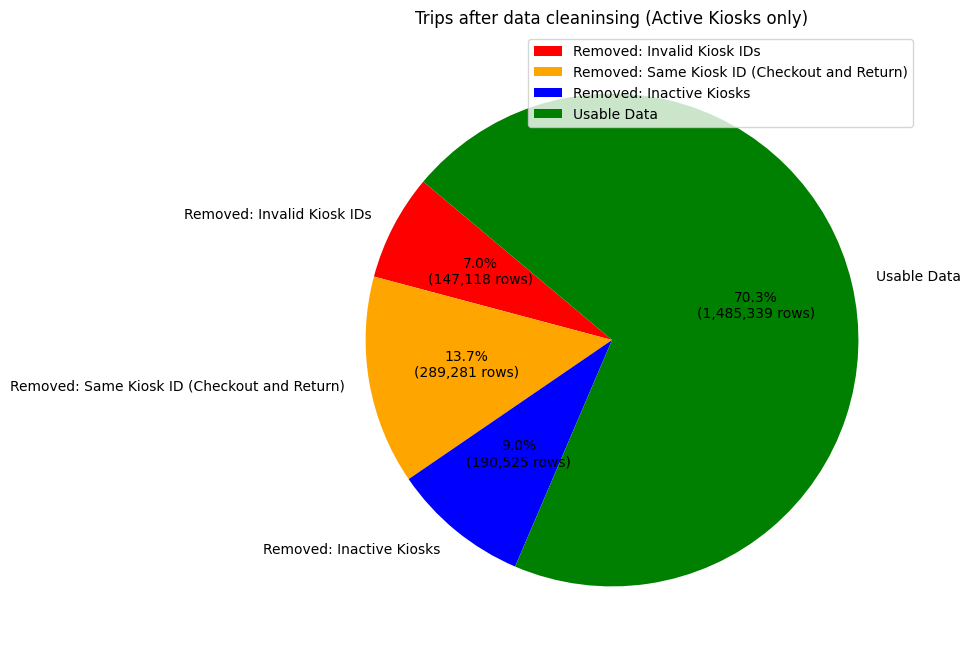

In [8]:
# Replace these counts with the actual lengths of your DataFrames
original_rows = len(data_df)
rows_after_invalid_kiosk_ids = len(filtered_df)
rows_after_checkout_return_filter = len(filtered_df2)
rows_on_active_kiosks = len(filtered_df3)

# Calculating the number of rows removed in each step
rows_removed_invalid_kiosk_ids = original_rows - rows_after_invalid_kiosk_ids
rows_removed_checkout_return_filter = rows_after_invalid_kiosk_ids - rows_after_checkout_return_filter
rows_removed_inactive_kiosks = rows_after_checkout_return_filter - rows_on_active_kiosks
usable_rows = rows_on_active_kiosks

# Labels for the pie chart
labels = [
    'Removed: Invalid Kiosk IDs', 
    'Removed: Same Kiosk ID (Checkout and Return)',
    'Removed: Inactive Kiosks',
    'Usable Data'
]

# Values for each slice of the pie chart
values = [
    rows_removed_invalid_kiosk_ids, 
    rows_removed_checkout_return_filter,
    rows_removed_inactive_kiosks,
    usable_rows
]

# Colors for each slice of the pie chart
colors = ['red', 'orange', 'blue', 'green']

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(values, labels=labels,colors = colors, autopct=lambda p: '{:.1f}%\n({:,.0f} rows)'.format(p, p * sum(values) / 100), startangle=140)
plt.title('Trips after data cleaninsing (Active Kiosks only)')
plt.legend()
plt.show()

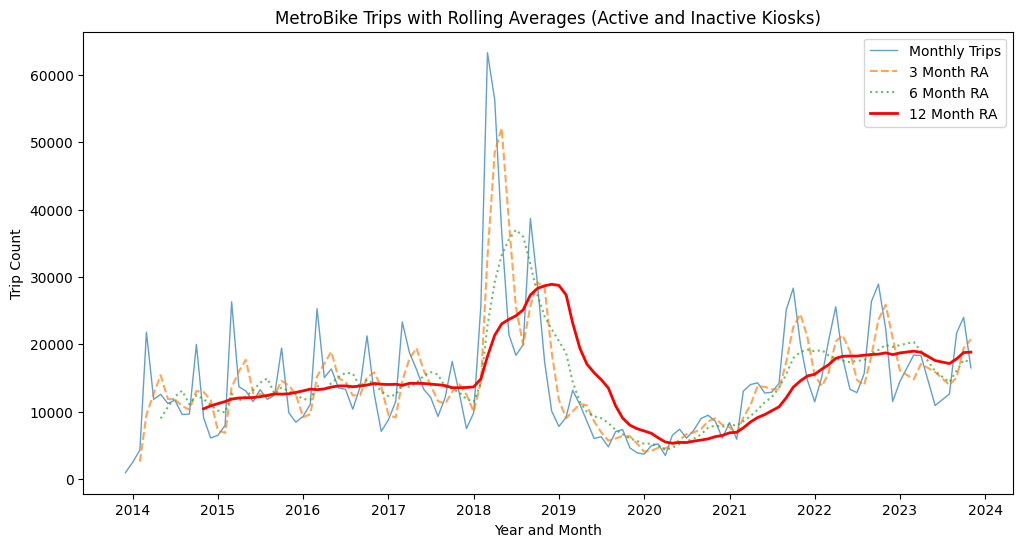

In [9]:
# Plotting the graph
plt.figure(figsize=(12, 6))
plt.plot(year_month_trip_df_all['Year_Month'], year_month_trip_df_all['Trip Count'], label='Monthly Trips', linewidth=1, alpha=0.7)
plt.plot(year_month_trip_df_all['Year_Month'], year_month_trip_df_all['3 Month MA'], label='3 Month RA', linestyle='--', alpha=0.7)
plt.plot(year_month_trip_df_all['Year_Month'], year_month_trip_df_all['6 Month MA'], label='6 Month RA', linestyle=':', alpha=0.7)
plt.plot(year_month_trip_df_all['Year_Month'], year_month_trip_df_all['12 Month MA'], label='12 Month RA', linestyle='-', linewidth=2, color='red')
plt.xlabel('Year and Month')
plt.ylabel('Trip Count')
plt.title('MetroBike Trips with Rolling Averages (Active and Inactive Kiosks)')
plt.legend()
plt.show()

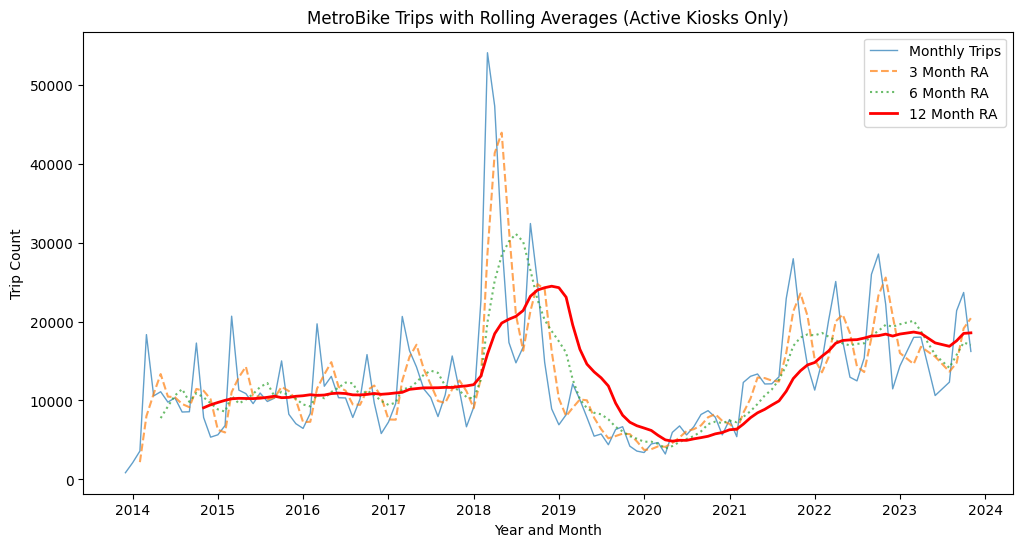

In [10]:
# Plotting the graph
plt.figure(figsize=(12, 6))
plt.plot(year_month_trip_df_active_only['Year_Month'], year_month_trip_df_active_only['Trip Count'], label='Monthly Trips', linewidth=1, alpha=0.7)
plt.plot(year_month_trip_df_active_only['Year_Month'], year_month_trip_df_active_only['3 Month MA'], label='3 Month RA', linestyle='--', alpha=0.7)
plt.plot(year_month_trip_df_active_only['Year_Month'], year_month_trip_df_active_only['6 Month MA'], label='6 Month RA', linestyle=':', alpha=0.7)
plt.plot(year_month_trip_df_active_only['Year_Month'], year_month_trip_df_active_only['12 Month MA'], label='12 Month RA', linestyle='-', linewidth=2, color='red')
plt.xlabel('Year and Month')
plt.ylabel('Trip Count')
plt.title('MetroBike Trips with Rolling Averages (Active Kiosks Only)')
plt.legend()
plt.show()

In [11]:
filtered_df3.to_json('../../data/processed/cleaned_metrobike_trips.json', orient='records')

In [12]:
kiosk_df = kiosk_df[kiosk_df['kiosk_status'] != 'closed']

# Reset the index of the DataFrame
kiosk_df = kiosk_df.reset_index(drop=True)

display(kiosk_df)

,kiosk_id,kiosk_name,kiosk_status,address,council_district,modified_date,:@computed_region_a3it_2a2z,:@computed_region_8spj_utxs,city_asset_num,property_type,number_of_docks,power_type,footprint_length_feet,footprint_width_feet,notes,alt_name,latitude,longitude
0,2707,Rainey St @ Cummings,active,1 Rainey St,9,2022-03-04T10:38:00.000,2856,9,16597.0,parkland,17.0,solar,50.0,5.0,parkland at ROW/easement,NaN,30.255906,-97.739949
1,3838,Nueces & 26th,active,600 W. 26th St.,9,2021-01-04T00:00:00.000,2860,9,16744.0,undetermined_parking,13.0,solar,40.0,5.0,NaN,NaN,30.29068,-97.74292
2,4051,10th & Red River,active,699 East 10th Street,1,2021-01-04T00:00:00.000,2856,1,32686.0,paid_parking,13.0,solar,40.0,5.0,NaN,NaN,30.27024,-97.73578
3,4061,Lakeshore @ Austin Hostel,active,2200 S Lakeshore Blvd,3,2021-01-04T00:00:00.000,3256,3,32692.0,nonmetered_parking,15.0,solar,45.0,5.0,NaN,NaN,30.24472,-97.72336
4,11,22nd 1/2 & Rio Grande,active,710 W. 22 1/2 St,9,2021-11-04T14:24:00.000,2860,9,NaN,sidewalk,4.0,solar,NaN,NaN,Kiosk ID & footprint length and width to be re...,NaN,30.2862,-97.74516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,4060,Red River/Cesar Chavez @ The Fairmont,active,101 Red River St.,9,2021-01-04T00:00:00.000,2856,9,32691.0,sidewalk,13.0,solar,40.0,5.0,NaN,NaN,30.26214,-97.7387
74,4062,Lakeshore & Pleasant Valley,active,2525 South Lakeshore Boulevard,3,2021-01-04T00:00:00.000,3256,3,32711.0,nonmetered_parking,18.0,solar,55.0,5.0,NaN,NaN,30.24258,-97.71726
75,4699,East 5th/Shady @ Eastside Bus Plaza,active,5104 East 5th. Street,3,2021-07-27T08:25:00.000,2857,3,32522.0,sidewalk,10.0,solar,15.0,10.0,NaN,NaN,30.25212,-97.69807
76,4879,16th/San Antonio,active,1601 San Antonio Street,9,2021-03-12T13:15:00.000,2856,9,16739.0,paid_parking,12.0,solar,40.0,5.0,NaN,NaN,30.27924,-97.74371


In [13]:
# Assuming filtered_df3 is your DataFrame with 'Checkout Kiosk ID' and 'Return Kiosk ID' columns
# Extract unique Kiosk IDs from both Checkout and Return columns
unique_checkout_kiosk_id_df = filtered_df3['Checkout Kiosk ID'].unique()
unique_return_kiosk_id_df = filtered_df3['Return Kiosk ID'].unique()

# Combine the unique values from both columns and remove duplicates
combined_unique_ids = pd.unique(np.concatenate((unique_checkout_kiosk_id_df, unique_return_kiosk_id_df)))

# Create a new DataFrame from the combined unique IDs
unique_kiosk_id_with_trips_df = pd.DataFrame(combined_unique_ids, columns=['Kiosk ID'])

# Display the DataFrame with unique Kiosk IDs
print("Unique Kiosk IDs from both Checkout and Return columns:")
display(unique_kiosk_id_with_trips_df)

# Identify kiosk_ids from kiosk_df that are not present in unique_kiosk_id_with_trips_df
kiosks_with_no_trips = kiosk_df[~kiosk_df['kiosk_id'].isin(unique_kiosk_id_with_trips_df['Kiosk ID'])]

# Display the DataFrame with kiosks that have no trips
print("Kiosks from kiosk_df that are not present in unique_kiosk_id_with_trips_df")
print("A.K.A Kiosks with no trips")
display(kiosks_with_no_trips)

Unique Kiosk IDs from both Checkout and Return columns:


,Kiosk ID
0,3793
1,2494
2,2501
3,2503
4,2495
...,...
70,4054
71,4055
72,0
73,2550


Kiosks from kiosk_df that are not present in unique_kiosk_id_with_trips_df
A.K.A Kiosks with no trips


,kiosk_id,kiosk_name,kiosk_status,address,council_district,modified_date,:@computed_region_a3it_2a2z,:@computed_region_8spj_utxs,city_asset_num,property_type,number_of_docks,power_type,footprint_length_feet,footprint_width_feet,notes,alt_name,latitude,longitude
4,11,22nd 1/2 & Rio Grande,active,710 W. 22 1/2 St,9,2021-11-04T14:24:00.000,2860,9,NaN,sidewalk,4.0,solar,NaN,NaN,Kiosk ID & footprint length and width to be re...,NaN,30.2862,-97.74516
5,111,23rd & San Gabriel,active,915 W 23rd St,9,2021-11-04T14:15:00.000,2860,9,NaN,paid_parking,13.0,solar,NaN,NaN,Kiosk ID and Footprint length & width to be re...,NaN,30.2874,-97.7478
6,1111,13th & Trinity,active,910 Trinity Street,1,2021-11-04T14:12:00.000,2856,1,NaN,sidewalk,13.0,solar,NaN,NaN,The Kiosk ID and footprint length & width stil...,NaN,30.2741,-97.73666


In [14]:
# Extract kiosk_id values from kiosks_with_no_trips
ids_to_remove = kiosks_with_no_trips['kiosk_id'].unique()

# Filter out rows where kiosk_id is in ids_to_remove from kiosk_df
kiosk_df = kiosk_df[~kiosk_df['kiosk_id'].isin(ids_to_remove)]

# Filter out rows where kiosk_id is 0
kiosk_df = kiosk_df[kiosk_df['kiosk_id'] != 0]

# Reset the index of the DataFrame
kiosk_df = kiosk_df.reset_index(drop=True)

display(kiosk_df)

kiosk_df.to_json('../../dist/data/processed/kiosk_coords.json', orient='records')
kiosk_df.to_csv('../../data/processed/Kiosk_with_LatLong.csv', index=False)

,kiosk_id,kiosk_name,kiosk_status,address,council_district,modified_date,:@computed_region_a3it_2a2z,:@computed_region_8spj_utxs,city_asset_num,property_type,number_of_docks,power_type,footprint_length_feet,footprint_width_feet,notes,alt_name,latitude,longitude
0,2707,Rainey St @ Cummings,active,1 Rainey St,9,2022-03-04T10:38:00.000,2856,9,16597.0,parkland,17.0,solar,50.0,5.0,parkland at ROW/easement,NaN,30.255906,-97.739949
1,3838,Nueces & 26th,active,600 W. 26th St.,9,2021-01-04T00:00:00.000,2860,9,16744.0,undetermined_parking,13.0,solar,40.0,5.0,NaN,NaN,30.29068,-97.74292
2,4051,10th & Red River,active,699 East 10th Street,1,2021-01-04T00:00:00.000,2856,1,32686.0,paid_parking,13.0,solar,40.0,5.0,NaN,NaN,30.27024,-97.73578
3,4061,Lakeshore @ Austin Hostel,active,2200 S Lakeshore Blvd,3,2021-01-04T00:00:00.000,3256,3,32692.0,nonmetered_parking,15.0,solar,45.0,5.0,NaN,NaN,30.24472,-97.72336
4,2494,2nd & Congress,active,151 E. 2nd St,9,2021-01-04T00:00:00.000,2856,9,16733.0,paid_parking,15.0,solar,45.0,5.0,NaN,NaN,30.26408,-97.74355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,4059,Nash Hernandez @ RBJ South,active,1316 Festival Beach Rd,3,2021-01-04T00:00:00.000,2857,3,32693.0,nonmetered_parking,13.0,solar,40.0,5.0,NaN,NaN,30.252,-97.7346
70,4060,Red River/Cesar Chavez @ The Fairmont,active,101 Red River St.,9,2021-01-04T00:00:00.000,2856,9,32691.0,sidewalk,13.0,solar,40.0,5.0,NaN,NaN,30.26214,-97.7387
71,4062,Lakeshore & Pleasant Valley,active,2525 South Lakeshore Boulevard,3,2021-01-04T00:00:00.000,3256,3,32711.0,nonmetered_parking,18.0,solar,55.0,5.0,NaN,NaN,30.24258,-97.71726
72,4699,East 5th/Shady @ Eastside Bus Plaza,active,5104 East 5th. Street,3,2021-07-27T08:25:00.000,2857,3,32522.0,sidewalk,10.0,solar,15.0,10.0,NaN,NaN,30.25212,-97.69807


array([2707, 3838, 4051, 4061, 2494, 2495, 2496, 2497, 2498, 2499, 2501,
       2503, 2504, 2537, 2539, 2542, 2544, 2547, 2548, 2549, 2550, 2552,
       2561, 2562, 2563, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572,
       2574, 2575, 2711, 2822, 2823, 3291, 3292, 3293, 3294, 3377, 3390,
       3513, 3619, 3621, 3660, 3684, 3685, 3686, 3687, 3790, 3791, 3792,
       3793, 3794, 3795, 3797, 3798, 3799, 4047, 4048, 4050, 4052, 4054,
       4055, 4057, 4058, 4059, 4060, 4062, 4699, 4879], dtype=int64)

74
[3793 2494 2501 2503 2495 3292 2567 2707 2552 2496 2571 2549 3390 3377
 2504 2566 2562 2574 2569 3291 2572 3838 2499 2575 2711 2548 2570 2497
 2537 3513 2563 2542 2498 2547 2561 3294 3621 3619 2568 2544 2822 2565
 3293 2539 4061 3794 2823 3660 4057 3687 3798 3797 4051 4058 3790 3795
 4062 3686 4050 4879 3799 4048 3791 4059 4047 3685 3684 4699 4052 4060
 4054 4055 2550 3792]
74
[2552 2504 2494 2501 2498 2503 2567 2542 2566 3793 3660 2497 2495 2549
 2711 2499 2537 2562 2547 3377 2707 2575 2548 3838 3513 2571 2563 3390
 2574 3292 2570 3291 3621 2572 2569 2565 3294 3619 2539 2561 2496 2822
 2544 3684 4061 4062 4699 3293 2823 3794 4879 3687 3799 3791 3797 3798
 4058 3790 3795 3686 4057 4050 4059 4048 4060 4055 3685 4047 4054 2568
 4051 4052 2550 3792]
74


,Checkout Kiosk ID,Return Kiosk ID,Count
3948,3795,3798,22621
4091,3798,3795,20636
4238,3838,3798,14366
4090,3798,3794,13227
3876,3794,3798,12792
...,...,...,...
1771,2568,3792,1
2427,2822,3792,1
2717,3293,3791,1
3743,3792,4058,1


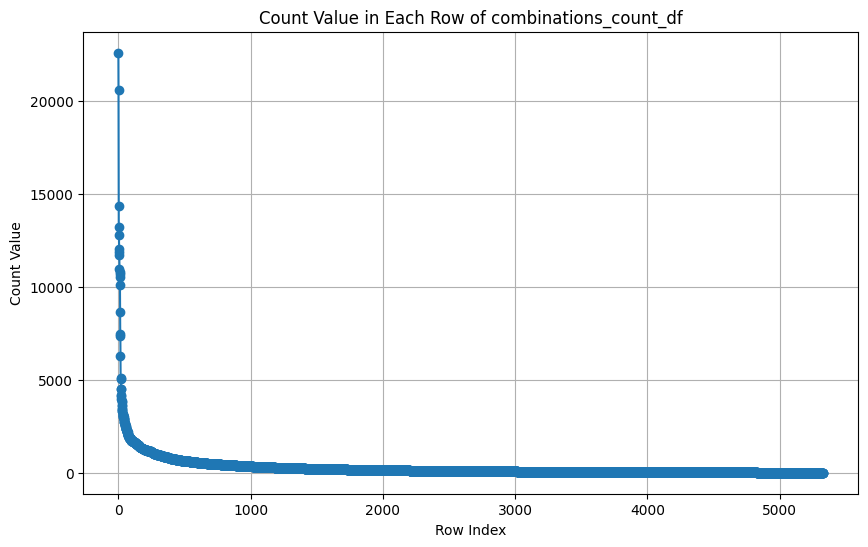


AIC and BIC values for all tested distributions:
  Distribution           AIC           BIC
0      poisson  3.423708e+06  3.423715e+06
1         norm  8.660026e+04  8.661342e+04
2        expon  7.040683e+04  7.041999e+04
3      lognorm  6.706612e+04  6.708586e+04
4  weibull_min  6.743657e+04  6.745632e+04
5  weibull_max  1.481767e+05  1.481965e+05


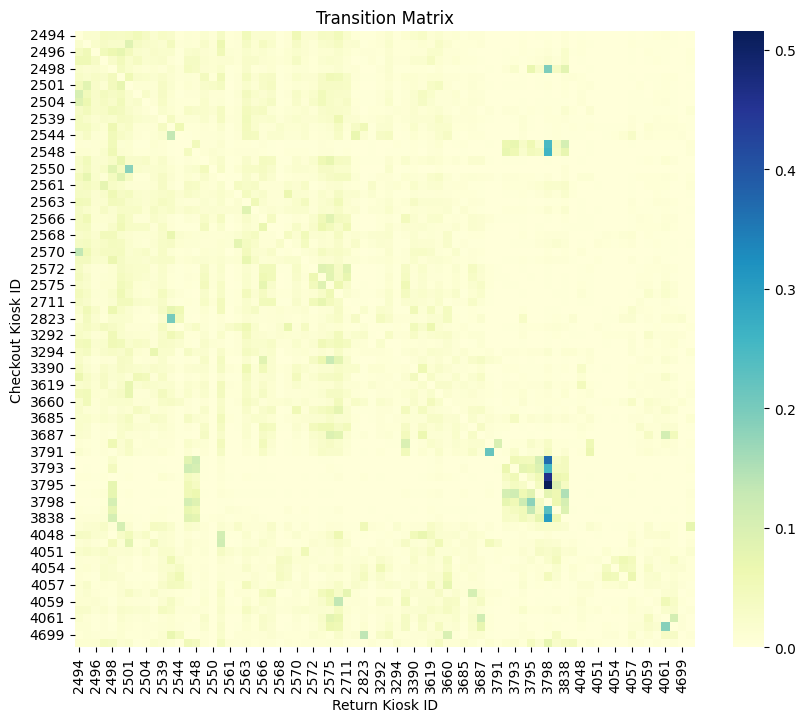

In [24]:
# List of valid kiosk IDs
valid_kiosk_ids = kiosk_df['kiosk_id'].unique()

display(valid_kiosk_ids)
print(len(valid_kiosk_ids))

# Filter rows where both 'Checkout Kiosk ID' and 'Return Kiosk ID' are in valid_kiosk_ids
filtered_df4 = filtered_df3[filtered_df3['Checkout Kiosk ID'].isin(valid_kiosk_ids) & 
                            filtered_df3['Return Kiosk ID'].isin(valid_kiosk_ids)]

print(filtered_df4['Checkout Kiosk ID'].unique())
print(len(filtered_df4['Checkout Kiosk ID'].unique()))
print(filtered_df4['Return Kiosk ID'].unique())
print(len(filtered_df4['Return Kiosk ID'].unique()))

# Group by 'Checkout Kiosk ID' and 'Return Kiosk ID' and count occurrences
combinations_count_df = filtered_df4.groupby(['Checkout Kiosk ID', 'Return Kiosk ID']).size().reset_index(name='Count')

# Sorting the DataFrame by 'Count' in descending order
combinations_count_df = combinations_count_df.sort_values(by='Count', ascending=False)

display(combinations_count_df)

# Plotting the value of 'Count' in each row of the simulated 'combinations_count_df'
plt.figure(figsize=(10, 6))
plt.plot(combinations_count_df['Count'].values, marker='o')
plt.title('Count Value in Each Row of combinations_count_df')
plt.xlabel('Row Index')
plt.ylabel('Count Value')
plt.grid(True)
plt.show()

#Testing distributions

data = combinations_count_df['Count']

# List of distributions to test
distributions = [
    stats.norm,         # Normal Distribution
    stats.expon,        # Exponential Distribution
    stats.lognorm,      # Log-Normal Distribution
    stats.weibull_min,  # Weibull Minimum (or Weibull) Distribution
    stats.weibull_max  # Weibull Maximum Distribution
]

# Store the results
results = []

# Poisson distribution
lambda_poisson = np.mean(data)
log_likelihood_poisson = np.sum(stats.poisson.logpmf(data, lambda_poisson))
aic_poisson = -2*log_likelihood_poisson + 2
bic_poisson = -2*log_likelihood_poisson + np.log(len(data))
results.append(('poisson', aic_poisson, bic_poisson))

# Fit the data to each distribution and calculate AIC and BIC
for distribution in distributions:
    # Fit distribution to data
    params = distribution.fit(data)

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Calculate the log likelihood
    log_likelihood = np.sum(distribution.logpdf(data, *arg, loc=loc, scale=scale))

    # Calculate AIC and BIC
    aic = -2*log_likelihood + 2*len(params)
    bic = -2*log_likelihood + len(params)*np.log(len(data))

    # Append results
    results.append((distribution.name, aic, bic))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Distribution', 'AIC', 'BIC'])

# Print AIC and BIC values for all distribution fits
print("\nAIC and BIC values for all tested distributions:")
print(results_df)

# Fit the log-normal distribution to the data
params = stats.lognorm.fit(data)

# Separate parts of parameters
arg = params[:-2]
loc = params[-2]
scale = params[-1]

# Calculate KS statistic and p-value
ks_statistic, ks_p_value = stats.kstest(data, 'lognorm', args=(arg, loc, scale))

ks_statistic, ks_p_value

# combinations_count_df.to_json('../../dist/data/processed/trips_between_kiosks.json', orient='records')
# combinations_count_df.to_json('../../data/processed/trips_between_kiosks.json', orient='records')

Return Kiosk ID,2494,2495,2496,2497,2498,2499,2501,2503,2504,2537,...,4054,4055,4057,4058,4059,4060,4061,4062,4699,4879
Checkout Kiosk ID,,,,,,,,,,,,,,,,,,,,,
2494,0.000000,0.019453,0.016878,0.036851,0.035262,0.032714,0.037865,0.051975,0.034605,0.016138,...,0.000466,0.000356,0.002548,0.001343,0.002849,0.004165,0.006137,0.002822,0.000301,0.002192
2495,0.019692,0.000000,0.022618,0.032390,0.024578,0.024812,0.090207,0.034263,0.024344,0.022910,...,0.000761,0.000497,0.004828,0.002224,0.003043,0.003921,0.002692,0.002984,0.000614,0.001873
2496,0.036763,0.053200,0.000000,0.049310,0.063829,0.076375,0.046132,0.022025,0.018080,0.026846,...,0.000657,0.001041,0.002192,0.001425,0.004602,0.003178,0.002137,0.001315,0.000384,0.004767
2497,0.056869,0.057477,0.034150,0.000000,0.027363,0.047474,0.022683,0.036293,0.019004,0.020612,...,0.000321,0.001143,0.002072,0.000786,0.002608,0.005644,0.003929,0.001572,0.000357,0.005501
2498,0.021921,0.015070,0.018612,0.012282,0.000000,0.040012,0.023773,0.013307,0.008596,0.013721,...,0.000521,0.000234,0.000683,0.000557,0.000432,0.000719,0.000575,0.000953,0.000252,0.002949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4060,0.027851,0.024204,0.010776,0.019728,0.007792,0.026028,0.022049,0.017407,0.016910,0.008786,...,0.004808,0.003979,0.013926,0.006797,0.011107,0.000000,0.020391,0.024867,0.003979,0.006466
4061,0.018323,0.008096,0.002983,0.007755,0.001449,0.018408,0.010312,0.007926,0.010482,0.003835,...,0.001364,0.000426,0.007755,0.006903,0.038009,0.007500,0.000000,0.107465,0.007585,0.001023
4062,0.011325,0.011081,0.002070,0.007306,0.003531,0.013517,0.009255,0.005602,0.006819,0.007185,...,0.002801,0.001583,0.011934,0.010351,0.027277,0.016196,0.185217,0.000000,0.006941,0.001705


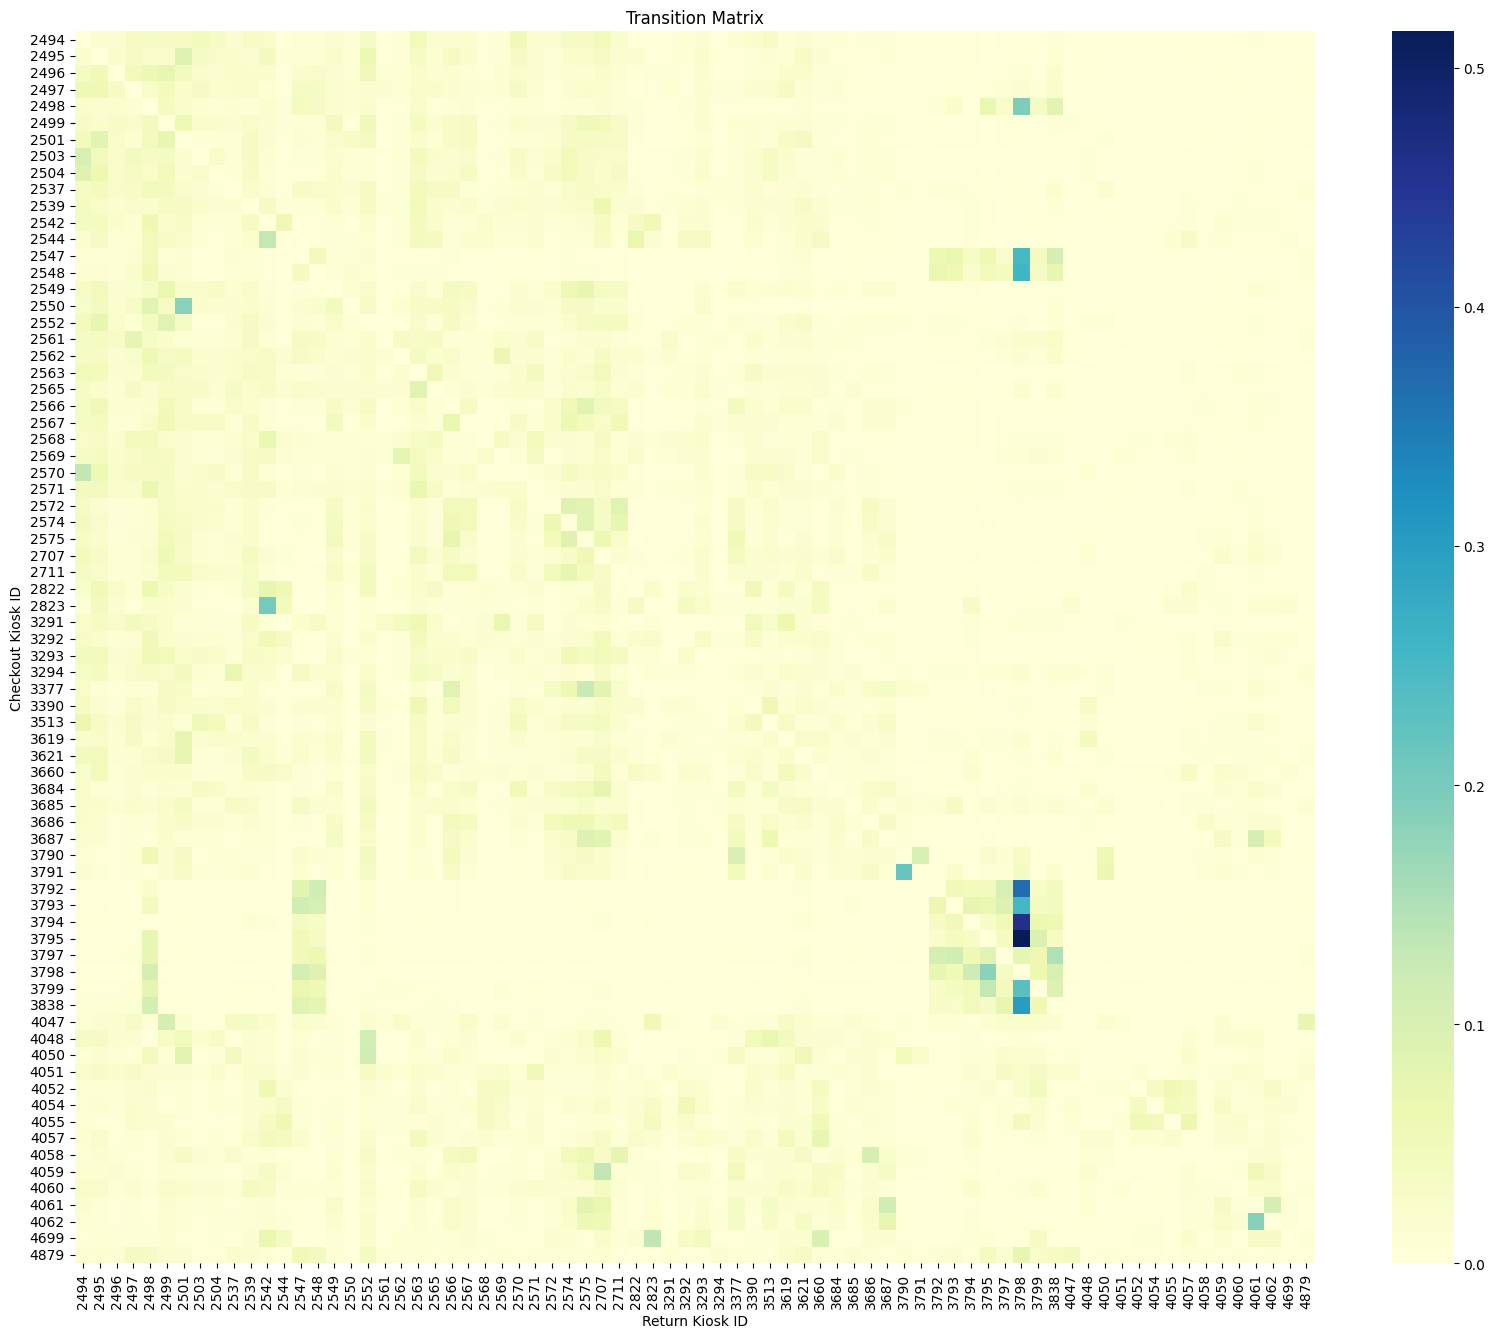

array([0.02805629, 0.02619058, 0.01273519, 0.01663174, 0.03967114,
       0.0299611 , 0.02568812, 0.01440616, 0.01228319, 0.01238955,
       0.01924419, 0.01535064, 0.00620152, 0.02843956, 0.02478496,
       0.01762082, 0.00648024, 0.02383731, 0.00393928, 0.00654733,
       0.02387484, 0.01185103, 0.02192146, 0.01678149, 0.00373478,
       0.00670363, 0.01517466, 0.00976385, 0.0128246 , 0.02432443,
       0.02792564, 0.02820686, 0.01762296, 0.0063428 , 0.00409112,
       0.00329765, 0.00625825, 0.01088703, 0.00353055, 0.01309971,
       0.01179117, 0.01251695, 0.01292738, 0.01447639, 0.00866241,
       0.00782835, 0.00509162, 0.00972806, 0.00940611, 0.00382279,
       0.00201913, 0.0166186 , 0.01682359, 0.01900506, 0.02788656,
       0.01563753, 0.07272348, 0.01815954, 0.02780001, 0.00204591,
       0.00440725, 0.00323397, 0.00119314, 0.00108448, 0.00092053,
       0.00110635, 0.0039191 , 0.0029969 , 0.00494861, 0.00402776,
       0.00831815, 0.00565058, 0.00118262, 0.00336366])

In [29]:
# Create a pivot table
transition_matrix = pd.pivot_table(combinations_count_df, values='Count', 
                                   index='Checkout Kiosk ID', 
                                   columns='Return Kiosk ID', 
                                   fill_value=0)

# Normalize the matrix
transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

display(transition_matrix)

plt.figure(figsize=(20, 16))
sns.heatmap(transition_matrix, cmap="YlGnBu")
plt.title("Transition Matrix")
plt.show()

#Need ti fix this logic

# Find the steady-state distribution
# This is a solution to the matrix equation πP = π where π is the steady-state vector
eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
stationary = eigenvectors[:, np.isclose(eigenvalues, 1)]
stationary = stationary / stationary.sum()

# Assuming the first eigenvector is the one we need (usually the case)
steady_state_distribution = stationary[:, 0].real

display(steady_state_distribution)